# Задание 2.

https://archive.ics.uci.edu/dataset/206/relative+location+of+ct+slices+on+axial+axis

ДЗ - на этом же датасете выполнить задачу классификации.

# Импорты библиотек

In [158]:
pip install catboost

In [159]:
from google.colab import files

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [161]:
from sklearn.preprocessing import KBinsDiscretizer

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

In [163]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

In [164]:
from sklearn.ensemble import RandomForestClassifier

In [165]:
from catboost import CatBoostClassifier

In [166]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [167]:
import warnings
warnings.filterwarnings('ignore')

## Функция сбора метрик для сравнения

In [168]:
def get_metrics(y_test, y_pred, y_score, name):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['R2'] = r2_score(y_test, y_pred)

    return df_metrics

# Постановка задачи:

определить слайс КТ (reference) по признакам.

# Загрузка данных

In [169]:
uploaded = files.upload()

Saving relative+location+of+ct+slices+on+axial+axis.zip to relative+location+of+ct+slices+on+axial+axis (1).zip


In [170]:
!unzip relative+location+of+ct+slices+on+axial+axis.zip

Archive:  relative+location+of+ct+slices+on+axial+axis.zip
replace slice_localization_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: slice_localization_data.csv  


# EDA

In [171]:
df = pd.read_csv('slice_localization_data.csv')

Описание датасета.

Данные были получены из набора из 53500 изображений КТ из 74 различных
пациентов (43 мужчины, 31 женщина).

Каждый срез КТ описывается двумя гистограммами в полярном пространстве.

Первая гистограмма описывает расположение костных структур на изображении.

Вторая - расположение воздушных включений внутри тела.

Обе гистограммы объединяются для формирования окончательного вектора признаков.
Бины, которые находятся за пределами изображения, помечаются значением -0,25.



In [172]:
df

,patientId,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.980381,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.803851
1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.745726
2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.687600
3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.629474
4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.976833,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.571348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,96,0.591906,0.357764,0.000000,0.000000,0.552321,0.795304,0.946697,0.952227,0.84395,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,29.290398
53496,96,0.612313,0.000000,0.000000,0.000000,0.864160,0.820531,0.000000,0.938813,0.94374,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,27.945721
53497,96,0.612313,0.000000,0.000000,0.000000,0.864160,0.820531,0.000000,0.938813,0.94374,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,27.945721
53498,96,0.634921,0.904555,0.956087,0.980208,0.157664,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.000000,0.0,0.994967,0.806688,0.0,0.0,-0.25,-0.25,14.582997


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53500 entries, 0 to 53499
Columns: 386 entries, patientId to reference
dtypes: float64(385), int64(1)
memory usage: 157.6 MB


В датасете 53500 строк, 386 колонок. Все признаки - числа.

In [174]:
print(df.dtypes)

patientId      int64
value0       float64
value1       float64
value2       float64
value3       float64
              ...   
value380     float64
value381     float64
value382     float64
value383     float64
reference    float64
Length: 386, dtype: object


Информация о переменных.

patientId: идентификатор пациента

2 - 241: переменые, описывающие костные структуры

242 - 385: переменные, описывающие воздушные включения

Каждый срез из множества срезов КТ одного пациента несет информацию о костных структурах (2-241), воздушных включениях (242-385). Значения равные 0 являются не костями или не воздухом соответствено. Значения равные - 0.25 - бины, находятся за пределами изображения.

386 - Целевая переменная. Значения находятся в диапазоне от 0 до 180, где 0 обозначает макушка головы и 180 подошвы ног.

Полагаю, что каждое значение датасета несет в себе смысловую нагрузку, даже бины и однородные колонки, и не должно быть удалено.
Слайсами составляется изображение.
Отсутствие информации - это тоже информация.

In [175]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patientId,53500.0,47.075701,27.414240,0.000000,23.000000,46.000000,70.000000,96.000000
value0,53500.0,0.059627,0.174243,0.000000,0.000000,0.000000,0.000000,1.000000
value1,53500.0,0.071558,0.196921,0.000000,0.000000,0.000000,0.000000,1.000000
value2,53500.0,0.145819,0.300270,0.000000,0.000000,0.000000,0.000000,1.000000
value3,53500.0,0.218728,0.359163,0.000000,0.000000,0.000000,0.446429,1.000000
...,...,...,...,...,...,...,...,...
value380,53500.0,0.266091,0.437633,0.000000,0.000000,0.000000,0.949478,1.000000
value381,53500.0,0.083049,0.279734,-0.250000,0.000000,0.000000,0.000000,0.999857
value382,53500.0,-0.031146,0.098738,-0.250000,0.000000,0.000000,0.000000,0.996839
value383,53500.0,-0.154524,0.122491,-0.250000,-0.250000,-0.250000,0.000000,0.942851


пропусков нет

диапазон всех признаков от -0.25 до 1, кроме patientId  

удалим колонку patientId (не несет смысловой нагрузки - не изображение)

масштабирование не нужно

Диапазон значений целевой переменной от 1.738733 до 97.489115

<Axes: >

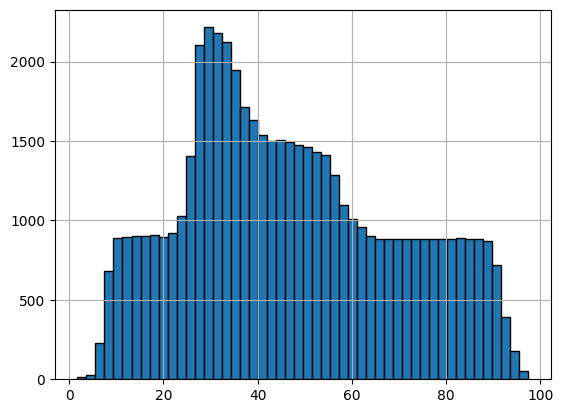

In [176]:
df['reference'].hist(bins=50, edgecolor='black')

Значит КТ было сделано от макушки до пояса пациента.

In [177]:
df['patientId'].value_counts() # распределение слайсов КТ по пациентам

patientId
46    1749
37    1410
41    1389
50    1358
85    1329
      ... 
24      81
38      80
68      75
30      67
63      66
Name: count, Length: 97, dtype: int64

<Axes: >

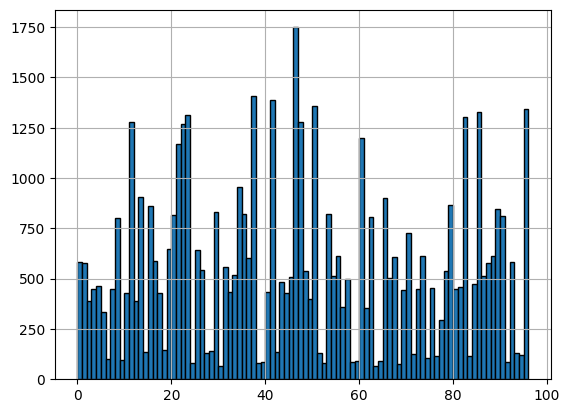

In [178]:
df['patientId'].hist(bins=96, edgecolor='black')

У пациентов разное количество слайсов КТ.

In [179]:
df_0 = df[df['patientId'] == 46]

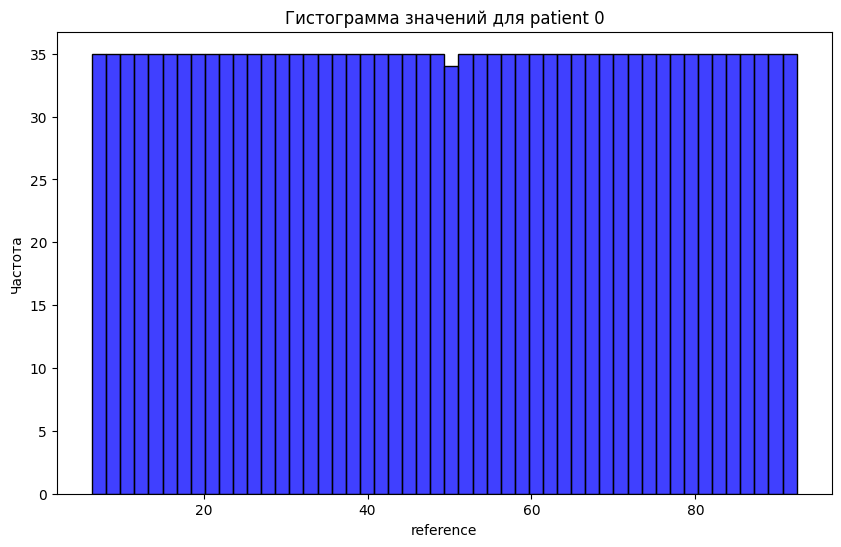

In [180]:
plt.figure(figsize=(10, 6))
sns.histplot(df_0['reference'], bins=50, kde=False, color='blue', edgecolor='black')
plt.title('Гистограмма значений для patient 0')
plt.xlabel('reference')
plt.ylabel('Частота')
plt.show()

46 пациент делал полное КТ от макушки до пояса

In [181]:
df_0 = df[df['patientId'] == 63]

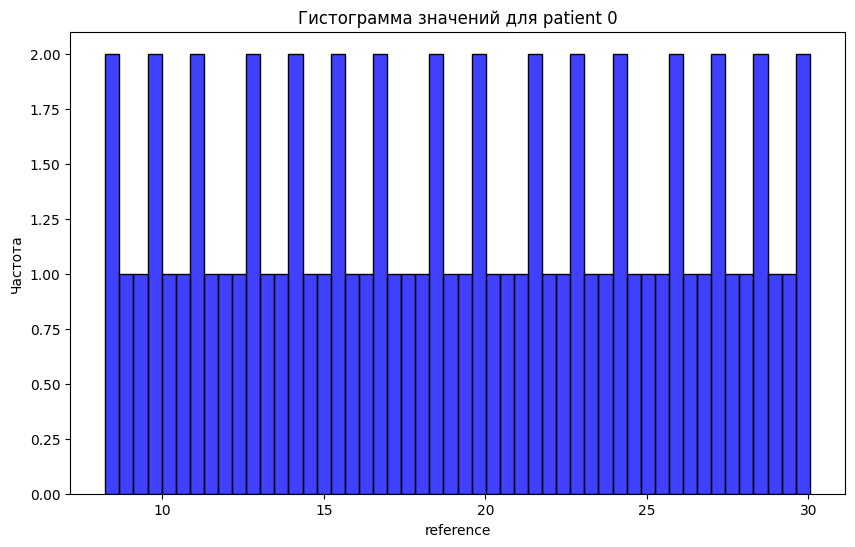

In [182]:
plt.figure(figsize=(10, 6))
sns.histplot(df_0['reference'], bins=50, kde=False, color='blue', edgecolor='black')
plt.title('Гистограмма значений для patient 0')
plt.xlabel('reference')
plt.ylabel('Частота')
plt.show()

63 пациент делал КТ от макушки до груди (возможно только голову)

# Расчет модели до обработки данных

In [183]:
X = df.drop('reference', axis=1)
y = df.reference

Дискретизация непрерывных меток

In [184]:
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

In [185]:
y = y.values.reshape(-1, 1)

In [186]:
y = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Логистическая регрессия

In [188]:
model_lg = LogisticRegression()

In [189]:
model_lg.fit(X_train, y_train)

LogisticRegression()

In [190]:
y_pred = model_lg.predict(X_test)

In [191]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9563364485981308

In [192]:
r2_score(y_test, y_pred)

0.9014590138112828

In [193]:
y_score = model_lg.predict_proba(X_test)

In [194]:
metrics_lg_0 = get_metrics(y_test, y_pred, y_score, name='LogisticRegression_0')
metrics_lg_0

,model,Accuracy,R2
0,LogisticRegression_0,0.956336,0.901459


## Случайный лес

In [195]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [196]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [197]:
y_pred = rf_model.predict(X_test)

In [198]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9968598130841122

In [199]:
r2_score(y_test, y_pred )

0.9943149431044971

In [200]:
y_score = rf_model.predict_proba(X_test)

In [201]:
metrics_rf_0 = get_metrics(y_test, y_pred, y_score, name='RandomForestClassifier_0')
metrics_rf_0

,model,Accuracy,R2
0,RandomForestClassifier_0,0.99686,0.994315


## Бустинг

In [202]:
model_cat = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='MultiClass',
                           verbose=0)

In [203]:
model_cat.fit(X_train, y_train)

In [204]:
y_pred = model_cat.predict(X_test)

In [205]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9754018691588785

In [206]:
r2_score(y_test, y_pred )

0.9453151670051624

In [207]:
y_score = model_cat.predict_proba(X_test)

In [208]:
metrics_cat_0 = get_metrics(y_test, y_pred, y_score, name='CatBoostClassifier_0')
metrics_cat_0

,model,Accuracy,R2
0,CatBoostClassifier_0,0.975402,0.945315


## KKN

In [209]:
k = 10  # количество соседей
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [210]:
y_pred = knn_model.predict(X_test)

In [211]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.994392523364486

In [212]:
r2_score(y_test, y_pred )

0.9878177352239224

In [213]:
y_score = knn_model.predict_proba(X_test)

In [214]:
metrics_knn_0 = get_metrics(y_test, y_pred, y_score, name='KNeighborsClassifier_0')
metrics_knn_0

,model,Accuracy,R2
0,KNeighborsClassifier_0,0.994393,0.987818


# Предобработка данных

In [215]:
# удаление patientId
df_clear = df.drop('patientId', axis = 1)

In [216]:
df_clear

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,-0.250000,...,-0.25,0.980381,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.803851
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,-0.250000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.745726
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,-0.250000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.687600
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,-0.250000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.629474
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,-0.250000,...,-0.25,0.976833,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.571348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,0.591906,0.357764,0.000000,0.000000,0.552321,0.795304,0.946697,0.952227,0.84395,0.798303,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,29.290398
53496,0.612313,0.000000,0.000000,0.000000,0.864160,0.820531,0.000000,0.938813,0.94374,0.868504,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,27.945721
53497,0.612313,0.000000,0.000000,0.000000,0.864160,0.820531,0.000000,0.938813,0.94374,0.868504,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,27.945721
53498,0.634921,0.904555,0.956087,0.980208,0.157664,0.000000,-0.250000,-0.250000,-0.25000,-0.250000,...,-0.25,0.000000,0.0,0.994967,0.806688,0.0,0.0,-0.25,-0.25,14.582997


# Разделение датасета

In [217]:
X = df_clear.drop('reference', axis=1)
y = df_clear.reference

# Дискретизация непрерывных меток (reference)

In [218]:
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

In [219]:
y = y.values.reshape(-1, 1)

In [220]:
y = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Модель Логистическая регрессия

In [222]:
model_lg = LogisticRegression()

In [223]:
model_lg.fit(X_train, y_train)

LogisticRegression()

In [224]:
y_pred = model_lg.predict(X_test)

In [225]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.974803738317757

In [226]:
r2_score(y_test, y_pred)

0.9417958460698511

In [227]:
y_score = model_lg.predict_proba(X_test)

In [228]:
metrics_lg = get_metrics(y_test, y_pred, y_score, name='LogisticRegression')
metrics_lg

,model,Accuracy,R2
0,LogisticRegression,0.974804,0.941796


# Модель Случайный лес

In [229]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [230]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [231]:
y_pred = rf_model.predict(X_test)

In [232]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.996785046728972

In [233]:
r2_score(y_test, y_pred )

0.9941795846069851

In [234]:
y_score = rf_model.predict_proba(X_test)

In [235]:
metrics_rf = get_metrics(y_test, y_pred, y_score, name='RandomForestClassifier')
metrics_rf

,model,Accuracy,R2
0,RandomForestClassifier,0.996785,0.99418


# Модель CatBoost

In [236]:
model_cat = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='MultiClass',
                           verbose=0)

In [237]:
model_cat.fit(X_train, y_train)

In [238]:
y_pred = model_cat.predict(X_test)

In [239]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9749532710280374

In [240]:
r2_score(y_test, y_pred )

0.9465333934827702

In [241]:
y_score = model_cat.predict_proba(X_test)

In [242]:
metrics_cat = get_metrics(y_test, y_pred, y_score, name='CatBoostClassifier')
metrics_cat

,model,Accuracy,R2
0,CatBoostClassifier,0.974953,0.946533


# Модель k-ближайших соседей

In [243]:
k = 10  # количество соседей
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [244]:
y_pred = knn_model.predict(X_test)

In [245]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9951401869158879

In [246]:
r2_score(y_test, y_pred )

0.9907956221691857

In [247]:
y_score = knn_model.predict_proba(X_test)

In [248]:
metrics_knn = get_metrics(y_test, y_pred, y_score, name='KNeighborsClassifier')
metrics_knn

,model,Accuracy,R2
0,KNeighborsClassifier,0.99514,0.990796


# Таблица сравнения моделей

In [249]:
first_row_df1 = metrics_lg.iloc[[0]]
first_row_df2 = metrics_rf.iloc[[0]]
first_row_df3 = metrics_cat.iloc[[0]]
first_row_df4 = metrics_knn.iloc[[0]]
first_row_df5 = metrics_lg_0.iloc[[0]]
first_row_df6 = metrics_rf_0.iloc[[0]]
first_row_df7 = metrics_cat_0.iloc[[0]]
first_row_df8 = metrics_knn_0.iloc[[0]]

In [250]:
first_rows_combined = pd.concat([first_row_df1, first_row_df2, first_row_df3, first_row_df4, first_row_df5, first_row_df6, first_row_df7, first_row_df8], axis=0)

In [251]:
remaining_rows_combined = pd.concat([metrics_lg.iloc[1:], metrics_rf.iloc[1:], metrics_cat.iloc[1:], metrics_knn.iloc[1:], metrics_lg_0.iloc[1:], metrics_rf_0.iloc[1:], metrics_cat_0.iloc[1:], metrics_knn_0.iloc[1:]], axis=0)

In [252]:
final_combined_df = pd.concat([first_rows_combined, remaining_rows_combined], axis=0).reset_index(drop=True)

In [253]:
final_combined_df = final_combined_df.sort_values(by='R2', ascending=False)
print(final_combined_df)

                      model  Accuracy        R2
5  RandomForestClassifier_0  0.996860  0.994315
1    RandomForestClassifier  0.996785  0.994180
3      KNeighborsClassifier  0.995140  0.990796
7    KNeighborsClassifier_0  0.994393  0.987818
2        CatBoostClassifier  0.974953  0.946533
6      CatBoostClassifier_0  0.975402  0.945315
0        LogisticRegression  0.974804  0.941796
4      LogisticRegression_0  0.956336  0.901459


# Нейронная сеть MLP Classifier

In [254]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [255]:
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)

In [256]:
model_mlp.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=42)

In [257]:
y_pred = model_mlp.predict(X_test)

In [258]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.995588785046729

In [259]:
r2_score(y_test, y_pred )

0.9920138486467935

In [260]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4388
           1       1.00      0.99      0.99      5867
           2       1.00      1.00      1.00      3120

    accuracy                           1.00     13375
   macro avg       1.00      1.00      1.00     13375
weighted avg       1.00      1.00      1.00     13375



# Вывод:

Наилучший результат показала модель Случайный лес без обработки данных. Хотя обработка была несущественная, видимо наличие ID пациентов помогает модели лучше обучиться.

Ситуация обратная у остальных моделей, метрики выше на обработанных данных.

Нейронная сеть MLP занимает третье место, уступай модели случайный лес (с обработкой и без).